In [1]:
import os
import torch
import scipy.io
import torch.nn as nn  # Import nn module
import torch.optim as optim  # Import optim module
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from hyperspectral_dataset import HyperspectralDataset, compute_statistics, NormalizeCube, NormalizeProfile

from pnet import pNet

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Function to get all file paths from a dataset
def get_all_file_paths(dataset):
    file_paths = []
    for idx in range(len(dataset)):
        file_paths.append(dataset.get_image_path(idx))
    return file_paths

# # Initialize the dataset with transformations
dataset = HyperspectralDataset(root_dir='../../ummdsRP/all')
# channel_means_cube, channel_stds_cube, channel_means_profile, channel_stds_profile = compute_statistics(dataset)

channel_means_cube, channel_stds_cube, channel_means_profile, channel_stds_profile = [0.5] * 31, [0.5] * 31, [0.5] * 31, [0.5] * 31
# Define the custom transformations using the computed statistics
cube_transform = NormalizeCube(mean=channel_means_cube, std=channel_stds_cube)
profile_transform = NormalizeProfile(mean=channel_means_profile, std=channel_stds_profile)

# Apply the custom transforms to the datasets
train_dataset = HyperspectralDataset(root_dir='../../ummdsRP/train', cube_transform=cube_transform, profile_transform=profile_transform)
val_dataset = HyperspectralDataset(root_dir='../../ummdsRP/val', cube_transform=cube_transform, profile_transform=profile_transform)
test_dataset = HyperspectralDataset(root_dir='../../ummdsRP/test', cube_transform=cube_transform, profile_transform=profile_transform)

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=48, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=48, shuffle=False, num_workers=4)

Label mapping: {'GP': 0, 'GN': 1}
Label mapping: {'GP': 0, 'GN': 1}
Label mapping: {'GP': 0, 'GN': 1}
Label mapping: {'GP': 0, 'GN': 1}


In [3]:
# Get file paths for the main dataset and each split
main_dataset_paths = get_all_file_paths(dataset)
train_dataset_paths = get_all_file_paths(train_dataset)
val_dataset_paths = get_all_file_paths(val_dataset)
test_dataset_paths = get_all_file_paths(test_dataset)

# Check if the total length of the splits equals the length of the main dataset
total_split_length = len(train_dataset_paths) + len(val_dataset_paths) + len(test_dataset_paths)
if total_split_length != len(main_dataset_paths):
    print(f"Error: Total length of splits ({total_split_length}) does not equal length of main dataset ({len(main_dataset_paths)})")
else:
    print("Total length of splits matches the length of the main dataset.")

# Check for overlaps between splits
def check_for_overlaps(paths1, paths2):
    overlaps = set(paths1) & set(paths2)
    return overlaps

train_val_overlaps = check_for_overlaps(train_dataset_paths, val_dataset_paths)
train_test_overlaps = check_for_overlaps(train_dataset_paths, test_dataset_paths)
val_test_overlaps = check_for_overlaps(val_dataset_paths, test_dataset_paths)

if train_val_overlaps:
    print(f"Error: Overlaps found between train and validation datasets: {len(train_val_overlaps)} overlaps")
else:
    print("No overlaps found between train and validation datasets.")

if train_test_overlaps:
    print(f"Error: Overlaps found between train and test datasets: {len(train_test_overlaps)} overlaps")
else:
    print("No overlaps found between train and test datasets.")

if val_test_overlaps:
    print(f"Error: Overlaps found between validation and test datasets: {len(val_test_overlaps)} overlaps")
else:
    print("No overlaps found between validation and test datasets.")

Total length of splits matches the length of the main dataset.
No overlaps found between train and validation datasets.
No overlaps found between train and test datasets.
No overlaps found between validation and test datasets.


In [4]:
model = pNet().to(device)

In [5]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

In [6]:
import time

# Initialize lists to store the metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
lr_change_epochs = []

# Training loop
num_epochs = 200
total_start_time = time.time()  # Start timer for the whole training process

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start timer for this epoch

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for _, profiles, labels in train_loader:
        profiles, labels = profiles.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(profiles)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for _, profiles, labels in val_loader:
            profiles, labels = profiles.to(device), labels.to(device)  # Move data to GPU
            outputs = model(profiles)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Step the scheduler based on validation loss and track LR changes
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        lr_change_epochs.append(epoch)
        print(f"Learning rate reduced from {old_lr} to {new_lr}")

    epoch_end_time = time.time()  # End timer for this epoch
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f} seconds")

total_end_time = time.time()  # End timer for the whole training process
total_duration = total_end_time - total_start_time
print(f"Training completed in {total_duration:.2f} seconds")


Epoch [1/200], Loss: 0.6741, Training Accuracy: 57.26%
Validation Loss: 0.6789, Validation Accuracy: 53.38%
Epoch [1/200] completed in 42.91 seconds
Epoch [2/200], Loss: 0.6667, Training Accuracy: 59.37%
Validation Loss: 0.6722, Validation Accuracy: 57.50%
Epoch [2/200] completed in 46.92 seconds
Epoch [3/200], Loss: 0.6658, Training Accuracy: 59.71%
Validation Loss: 0.6687, Validation Accuracy: 58.38%
Epoch [3/200] completed in 89.43 seconds
Epoch [4/200], Loss: 0.6636, Training Accuracy: 59.99%
Validation Loss: 0.6651, Validation Accuracy: 61.25%
Epoch [4/200] completed in 38.14 seconds
Epoch [5/200], Loss: 0.6624, Training Accuracy: 59.66%
Validation Loss: 0.6644, Validation Accuracy: 58.88%
Epoch [5/200] completed in 37.73 seconds
Epoch [6/200], Loss: 0.6621, Training Accuracy: 60.00%
Validation Loss: 0.6646, Validation Accuracy: 60.38%
Epoch [6/200] completed in 36.97 seconds
Epoch [7/200], Loss: 0.6625, Training Accuracy: 59.64%
Validation Loss: 0.6641, Validation Accuracy: 59.62

KeyboardInterrupt: 

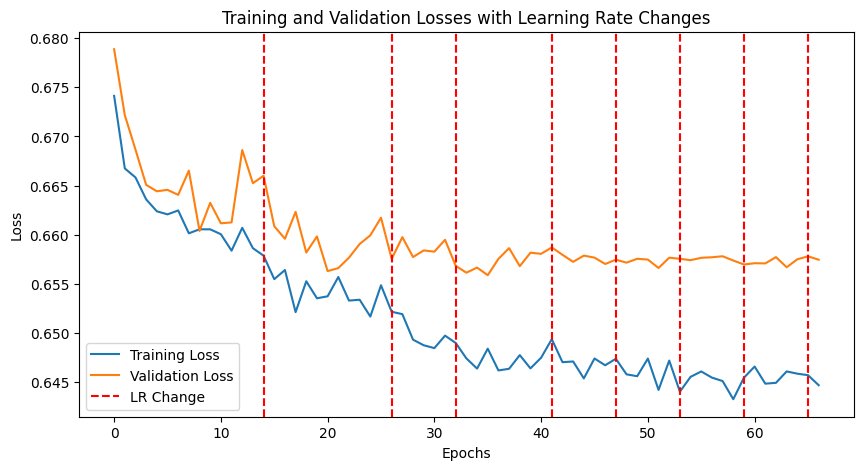

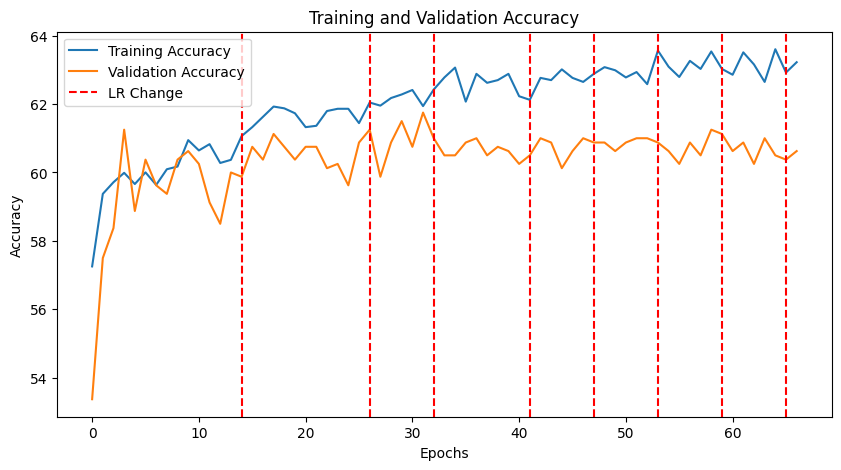

In [7]:
# Plot the training and validation losses with learning rate change points
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses with Learning Rate Changes')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [8]:
torch.save(model.state_dict(), 'pnet.pth')

In [9]:
for name, param in model.named_parameters():
    print(name)

conv1.weight
conv1.bias
batch_norm1.weight
batch_norm1.bias
dense1.weight
dense1.bias
dense2.weight
dense2.bias
